# Project 4: Unsupervised Learning
# Data Set: CIFAR-10 - Object Recognition in Images
_Identify the subject of 60,000 labeled images_

**Project Description**: _"[CIFAR-10](https://www.kaggle.com/c/cifar-10/)  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton."_

For this project, 2500 random images were selected.

## 1. Introduction

In [1]:
import numpy as np
import pandas as pd
import cv2
import time
import os, os.path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import seaborn as sns; sns.set_style("whitegrid")

#from keras.datasets import cifar10
#from google.colab.patches import cv2_imshow

***
***
**Sandbox Cells:**<br>

In [2]:
os.listdir("train/")[0:5]

['1.png', '10.png', '100.png', '1000.png', '10000.png']

In [3]:
os.path.splitext(os.listdir("train")[1])

('10', '.png')

***
---

In [4]:
# labels of the 50,000 train images
df_labels = pd.read_csv("trainLabels.csv", index_col="id")

# For convenience, convert the labels to numbers in alphabetical order
df_labels["label #"] = df_labels.label
labels_ordered = enumerate(sorted(df_labels.label.unique()), start=0)
for num, label in labels_ordered:
    df_labels["label #"].replace(to_replace=label, value=num, inplace=True)
df_labels["label #"] = df_labels["label #"].astype("uint8")
del labels_ordered

df_labels.head()

,label,label #
id,,
1,frog,6
2,truck,9
3,truck,9
4,deer,4
5,automobile,1


In [5]:
%%time

# Here we create indices for 2500 random images
np.random.seed(42)
indices = np.random.choice(50000,2500)

# To make things faster, numpy arrays were formed
# They will be concatenated later on a DataFrame
image_array = np.empty(shape=(2500,2500), dtype="uint8")    ## u can make these simpler
label_array = np.empty(shape=(2500,1), dtype="object")
label_num = np.empty(shape=(2500,1), dtype="uint8")
name_array = np.empty(shape=(2500,1), dtype="object")

# Now let's get the images and put them into numpy array we crated
for num, indx in enumerate(indices):
    path = f"train/{indx}.png"
    img_array = cv2.imread(path, 0)
    img_array = cv2.resize(img_array, (50,50))
    image_array[num] = img_array.reshape(-1)
    label_array[num] = df_labels.loc[indx, "label"]
    label_num[num] = df_labels.loc[indx, "label #"]
    name_array[num] = str(indx) + ".png"

# summon a DataFrame to work on them easier
train_df = pd.DataFrame(image_array)
train_df["Img Name"] = name_array
train_df["Label"] = label_array
train_df["Label #"] = label_num

Wall time: 1.83 s


In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2493,2494,2495,2496,2497,2498,2499,Img Name,Label,Label #
0,75,85,102,140,164,179,152,134,127,121,...,43,35,34,29,20,27,35,15795.png,cat,3
1,172,170,167,166,166,167,167,167,166,167,...,10,19,19,20,24,48,67,860.png,ship,8
2,74,75,77,74,68,61,79,92,98,95,...,82,82,81,81,82,82,82,38158.png,automobile,1
3,240,239,238,238,239,240,240,240,239,239,...,44,33,28,25,25,32,38,44732.png,airplane,0
4,249,247,245,245,244,243,243,243,243,243,...,203,204,206,209,210,215,218,11284.png,airplane,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 2503 entries, 0 to Label #
dtypes: object(2), uint8(2501)
memory usage: 6.0+ MB


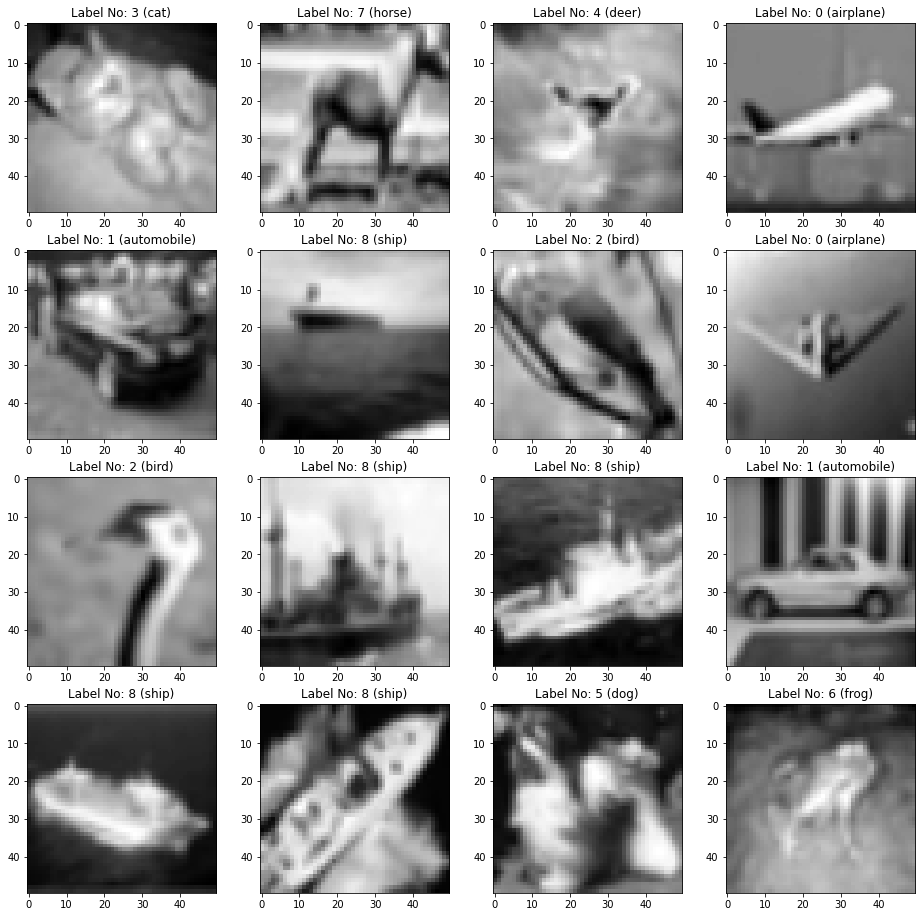

In [8]:
# some of the random choice images
plt.figure(figsize=(16,16))
subplot_num = 1
for i in np.random.randint(0,2500,16):
    plt.subplot(4,4,subplot_num)
    example = np.resize(train_df.iloc[i, :], (50,50)).astype("uint8")
    plt.imshow(example, cmap="gray")
    label = df_labels.loc[indices[i], "label"]
    label_no = train_df.loc[i, "Label #"]
    plt.title(f"Label No: {label_no} ({label})", size=12)
    subplot_num+=1
plt.show()
del subplot_num

## 2. Dimensionality Reduction Study

In [9]:
import seaborn as sns
sns.set_style("whitegrid")

# defining independent variables, X & Y
X = train_df.iloc[:, :-3]
Y = train_df["Label #"]

### 2.1. Principle Component Analysis (PCA)

In [10]:
from sklearn.decomposition import PCA

In [11]:
# standardize the values
X_std = X/255.0
# StandardScaler() would create negative values
# that causes error in PCA fit_transform()

In [12]:
# we'll see the variation distribution through the eigenvalues
def eig_vals():
    X_std_T = X_std.T
    C_X = np.cov(X_std_T)
    eig_val_cov, eig_vec_cov = np.linalg.eig(C_X)

    plt.figure(dpi=100)
    plt.plot(eig_val_cov)
    plt.xlim(0,150)
    plt.ylim(0,150)
    plt.show()
# eig_vals()    # skipped.

In [13]:
# let's take 100 components on our PCA model
pca_model = PCA(n_components=50)
X_pca = pca_model.fit_transform(X_std)

print(f"With {pca_model.n_components_} components, our model explains \
{sum(pca_model.explained_variance_ratio_)*100:.1f}% of our data.")

With 50 components, our model explains 90.0% of our data.


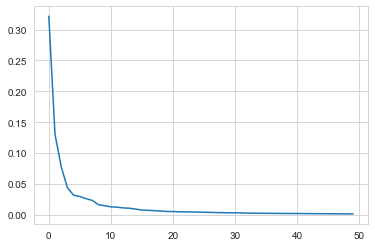

In [14]:
plt.plot(pca_model.explained_variance_ratio_)
plt.show()
# down below we see that n_components=40 
# would do the work as well with 88% of data.

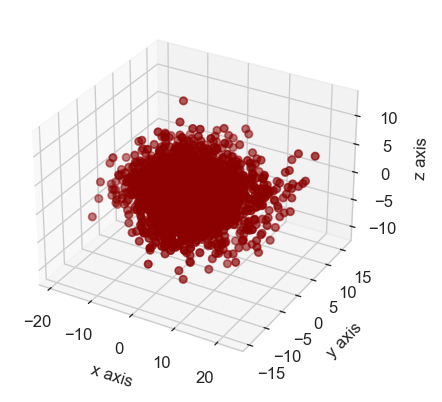

In [15]:
def plot_3D(independent_variable, interaction="passive", color="darkred"):
    """Note that, we have a bug:
    May need to run the cell a few times to view it in interactive mode."""
    if interaction == "passive":
        %matplotlib inline
    elif interaction == "active":
        %matplotlib notebook
    else:
        return "Only 'passive' & 'active' modes are valid."
    
    fig=plt.figure(dpi=120)
    ax=fig.add_subplot(111, projection="3d")

    ax.scatter(independent_variable.T[0], 
               independent_variable.T[1], 
               independent_variable.T[2], 
               color=color)
    ax.set_xlabel("x axis")
    ax.set_ylabel("y axis")
    ax.set_zlabel("z axis")
    plt.show()

plot_3D(X_pca, "passive")

In [16]:
# Not enough memory to run this cell. Needs to be fixed.
def pca_visualiser():
    for i in range(10):
        train_df.Label[train_df.Label == train_df.Label.unique()[i]] = i

    y = list(train_df.Label)

    plt.figure()
    colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
    
    for i in range(X_pca.shape[0]):
        plt.text(X_pca[i, 0], X_pca[i, 1], str(y[i]),
                 color=colours[int(y[i])],
                 fontdict={'weight': 'bold', 'size': 50})
    plt.xticks([])
    plt.yticks([])
    plt.show()

#%matplotlib inline 
#pca_visualiser()

### 2.2. t-distributed Stochastic Neighbor Embedding (t-SNE)

In [17]:
from sklearn.manifold import TSNE

In [18]:
# t-SNE model 1 with perplexity=5
time_start = time.time()
tsne_model1 = TSNE(n_components=3, 
                   perplexity=5, 
                   n_iter=1000, 
                   verbose=True, 
                   n_jobs=-1)
X_tsne1 = tsne_model1.fit_transform(X_std)
print(f"t-SNE is completed in {(time.time()-time_start):.1f} seconds.")

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2500 samples in 1.729s...
[t-SNE] Computed neighbors for 2500 samples in 13.292s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 1.776881
[t-SNE] KL divergence after 250 iterations with early exaggeration: 122.217972
[t-SNE] KL divergence after 1000 iterations: 2.622106
t-SNE is completed in 108.2 seconds.


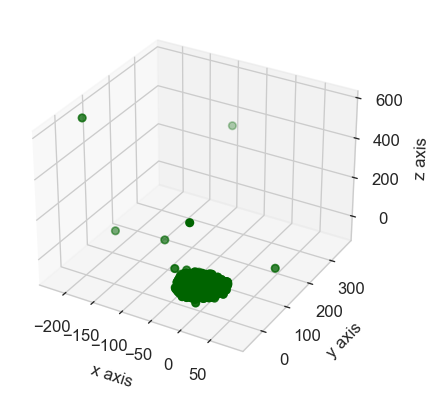

In [19]:
plot_3D(X_tsne1, "passive", "darkgreen")

In [20]:
# t-SNE model 1 with perplexity=40
time_start = time.time()
tsne_model2 = TSNE(n_components=3, 
                   perplexity=40, 
                   n_iter=1000, 
                   verbose=False, 
                   n_jobs=-1)
X_tsne2 = tsne_model2.fit_transform(X_std)
print(f"t-SNE is completed in {(time.time()-time_start):.1f} seconds.")

t-SNE is completed in 124.9 seconds.


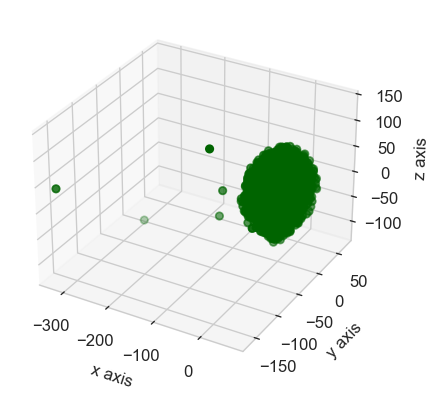

In [21]:
plot_3D(X_tsne2, "passive", "darkgreen")

### 2.3. Uniform Manifold Approximation and Projection (UMAP)

In [22]:
from umap import UMAP

In [23]:
# UMAP model 1
time_start = time.time()
umap_model1 = UMAP(n_neighbors=5,
                   min_dist=0.1,
                   metric="correlation", 
                   n_components=10, 
                   verbose=True)
X_umap1 = umap_model1.fit_transform(X_std)
print(f"UMAP modeling is completed in {(time.time()- time_start):.2f} seconds.")

UMAP(angular_rp_forest=True, metric='correlation', n_components=10,
     n_neighbors=5, verbose=True)
Construct fuzzy simplicial set
Fri Sep 25 20:51:28 2020 Finding Nearest Neighbors
Fri Sep 25 20:51:32 2020 Finished Nearest Neighbor Search
Fri Sep 25 20:51:36 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Sep 25 20:51:40 2020 Finished embedding
UMAP modeling is completed in 50.37 seconds.


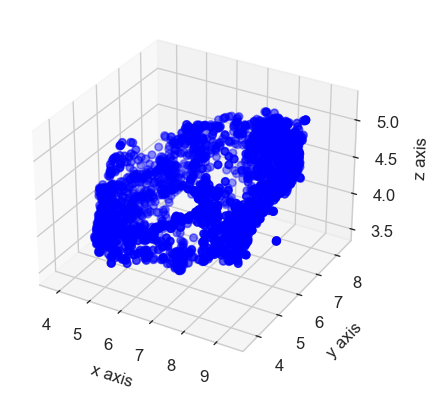

In [24]:
plot_3D(X_umap1, "passive", "blue")

In [25]:
# UMAP model 2
time_start = time.time()
umap_model2 = UMAP(n_neighbors=15,
                   min_dist=0.1,
                   metric="euclidean", 
                   n_components=10, 
                   verbose=False)
X_umap2 = umap_model2.fit_transform(X_std)
print(f"UMAP modeling is completed in {(time.time()- time_start):.2f} seconds.")

UMAP modeling is completed in 17.74 seconds.


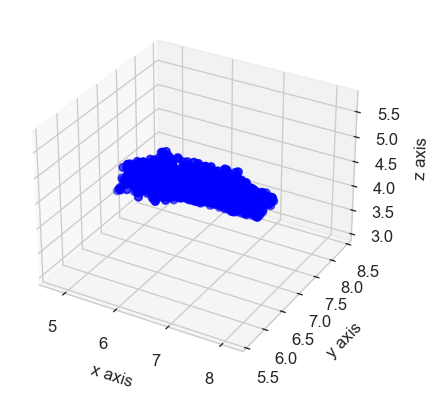

In [26]:
plot_3D(X_umap2, "passive", "blue")

# 3. Clustering Models

In [27]:
# variable list
var_list = ["X_std", "X_pca", "X_tsne1", "X_tsne2", "X_umap1", "X_umap2"]

# DataFrame for the predicted values
clusters_df = pd.DataFrame()
clusters_df["Img Name"] = train_df["Img Name"]
clusters_df["Label"] = train_df.Label
clusters_df["Label #"] = train_df["Label #"]

# DataFrame for the model scores
silhouette_df = pd.DataFrame(index=var_list)
silhouette_df.index.names = ["Variable"]
ari_df = pd.DataFrame(index=var_list)
ari_df.index.names = ["Variable"]

## 3.1. k-Means

In [28]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [29]:
# list of independent variables created above:
# X_std, X_pca, X_tsne1, X_tsne2, X_umap1, X_umap2

# function for KMeans model
def kmeans_model(var):
    """The Return is a list of length three: [y, z1, z2]
    y: prediction of your KMeans model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    Please use the indices 0, 1 & 2 to 
    get the returns y, z1 & z2 respectively.
    And remember: 'var' is your independent variable!"""
    kmodel = KMeans(n_clusters=10, random_state=42)
    y = kmodel.fit_predict(var)
    z1 = metrics.silhouette_score(X=var, 
                                 labels=y, 
                                 metric="euclidean")
    z2 = metrics.adjusted_rand_score(labels_true=Y, 
                                     labels_pred=y)
    return [y, z1, z2]

In [30]:
%%time
def add_to_cluster_df(model_name, model):
    clusters_df[f"{model_name}_std"] = model(X_std)[0]
    clusters_df[f"{model_name}_pca"] = model(X_pca)[0]
    clusters_df[f"{model_name}_tsne1"] = model(X_tsne1)[0]
    clusters_df[f"{model_name}_tsne2"] = model(X_tsne2)[0]
    clusters_df[f"{model_name}_umap1"] = model(X_umap1)[0]
    clusters_df[f"{model_name}_umap2"] = model(X_umap2)[0]
add_to_cluster_df("kmeans", kmeans_model)

Wall time: 12.1 s


In [31]:
def show_silhouette(model_name, model):
    silhouette_df.at["X_std", f"{model_name}"] = var1 = model(X_std)[1]
    silhouette_df.at["X_pca", f"{model_name}"] = var2 = model(X_pca)[1]
    silhouette_df.at["X_tsne1", f"{model_name}"] = var3 = model(X_tsne1)[1]
    silhouette_df.at["X_tsne2", f"{model_name}"] = var4 = model(X_tsne2)[1]
    silhouette_df.at["X_umap1", f"{model_name}"] = var5 = model(X_umap1)[1]
    silhouette_df.at["X_umap2", f"{model_name}"] = var6 = model(X_umap2)[1]
    print(f"Silhouette score of '{model_name}_std' model: {(var1):.3f}")
    print(f"Silhouette score of '{model_name}_pca' model: {(var2):.3f}")
    print(f"Silhouette score of '{model_name}_tsne1' model: {(var3):.3f}")
    print(f"Silhouette score of '{model_name}_tsne2' model: {(var4):.3f}")
    print(f"Silhouette score of '{model_name}_umap1' model: {(var5):.3f}")
    print(f"Silhouette score of '{model_name}_umap2' model: {(var6):.3f}")
show_silhouette("kmeans", kmeans_model)

Silhouette score of 'kmeans_std' model: 0.064
Silhouette score of 'kmeans_pca' model: 0.076
Silhouette score of 'kmeans_tsne1' model: 0.286
Silhouette score of 'kmeans_tsne2' model: 0.249
Silhouette score of 'kmeans_umap1' model: 0.320
Silhouette score of 'kmeans_umap2' model: 0.319


In [32]:
def show_ari(model_name, model):
    ari_df.at["X_std", f"{model_name}"] = var1 = model(X_std)[2]
    ari_df.at["X_pca", f"{model_name}"] = var2 = model(X_pca)[2]
    ari_df.at["X_tsne1", f"{model_name}"] = var3 = model(X_tsne1)[2]
    ari_df.at["X_tsne2", f"{model_name}"] = var4 = model(X_tsne2)[2]
    ari_df.at["X_umap1", f"{model_name}"] = var5 = model(X_umap1)[2]
    ari_df.at["X_umap2", f"{model_name}"] = var6 = model(X_umap2)[2]
    print(f"Adjusted Rand score of '{model_name}_std' model: {(var1):.4f}")
    print(f"Adjusted Rand score of '{model_name}_pca' model: {(var2):.4f}")
    print(f"Adjusted Rand score of '{model_name}_tsne1' model: {(var3):.4f}")
    print(f"Adjusted Rand score of '{model_name}_tsne2' model: {(var4):.4f}")
    print(f"Adjusted Rand score of '{model_name}_umap1' model: {(var5):.4f}")
    print(f"Adjusted Rand score of '{model_name}_umap2' model: {(var6):.4f}")
show_ari("kmeans", kmeans_model)

Adjusted Rand score of 'kmeans_std' model: 0.0356
Adjusted Rand score of 'kmeans_pca' model: 0.0357
Adjusted Rand score of 'kmeans_tsne1' model: 0.0357
Adjusted Rand score of 'kmeans_tsne2' model: 0.0330
Adjusted Rand score of 'kmeans_umap1' model: 0.0291
Adjusted Rand score of 'kmeans_umap2' model: 0.0302


## 3.2. Hierarchical (Agglomerative) Clustering

In [33]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

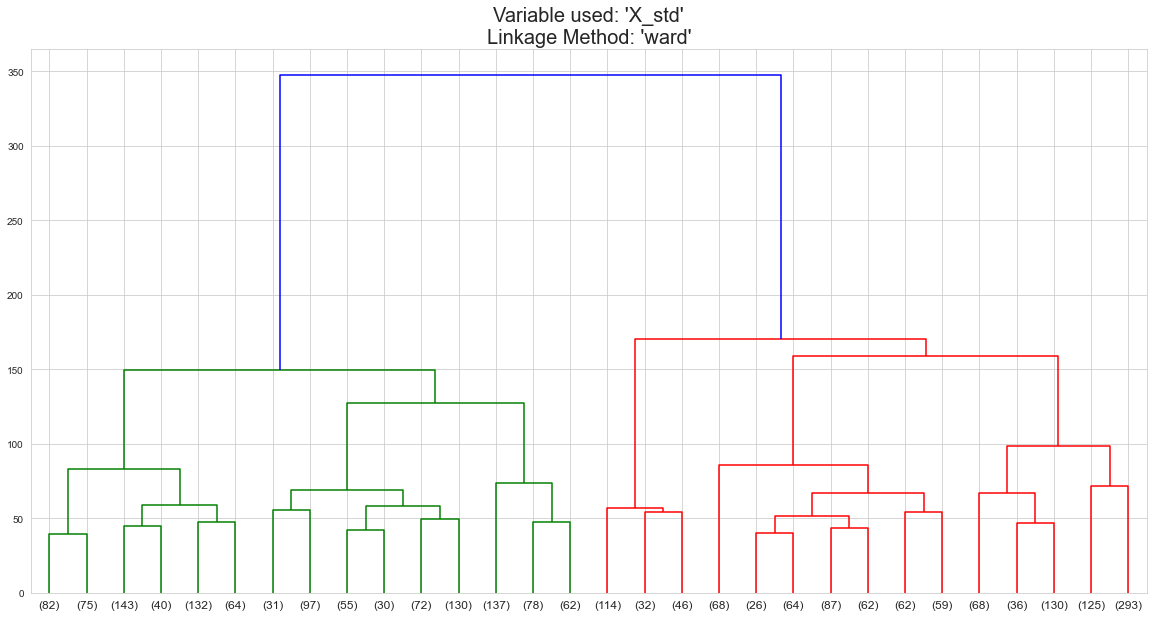

In [34]:
# dendrogram example with X_std variable
plt.figure(figsize=(20,10))
plt.title("Variable used: 'X_std'\nLinkage Method: 'ward'", size=20)
Z = linkage(X_std, 
            method="ward", 
            metric="euclidean")
dendrogram(Z=Z, 
           truncate_mode="lastp", 
           leaf_font_size=12, 
           leaf_rotation=0)
plt.show()

In [35]:
# list of independent variables created above:
# X_std, X_pca, X_tsne1, X_tsne2, X_umap1, X_umap2

# function for AgglomerativeClustering model
def aggClus_model(var):
    """The Return is a list of length three: [y, z1, z2]
    y: prediction of your AgglomerativeClustering model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    Please use the indices 0, 1 & 2 to 
    get the returns y, z1 & z2 respectively.
    And remember: 'var' is your independent variable!"""
    aggClus_model = AgglomerativeClustering(n_clusters=10,
                                            affinity="euclidean",
                                            linkage="ward")
    y = aggClus_model.fit_predict(var)
    z1 = metrics.silhouette_score(X=var, 
                                 labels=y, 
                                 metric="euclidean")
    z2 = metrics.adjusted_rand_score(labels_true=Y, 
                                     labels_pred=y)
    return [y, z1, z2]

In [36]:
%%time
add_to_cluster_df("aggClus", aggClus_model)

Wall time: 11.9 s


In [37]:
show_silhouette("aggClus", aggClus_model)

Silhouette score of 'aggClus_std' model: 0.025
Silhouette score of 'aggClus_pca' model: 0.038
Silhouette score of 'aggClus_tsne1' model: 0.233
Silhouette score of 'aggClus_tsne2' model: 0.163
Silhouette score of 'aggClus_umap1' model: 0.289
Silhouette score of 'aggClus_umap2' model: 0.245


In [38]:
show_ari("aggClus", aggClus_model)

Adjusted Rand score of 'aggClus_std' model: 0.0314
Adjusted Rand score of 'aggClus_pca' model: 0.0282
Adjusted Rand score of 'aggClus_tsne1' model: 0.0335
Adjusted Rand score of 'aggClus_tsne2' model: 0.0277
Adjusted Rand score of 'aggClus_umap1' model: 0.0322
Adjusted Rand score of 'aggClus_umap2' model: 0.0325


## 3.3. Density-based Spatial Clustering of Applications with Noise (DBSCAN)

In [39]:
from sklearn.cluster import DBSCAN

In [40]:
def dbscan_model(var):
    """The Return is a list of length three: [y, z1, z2]
    y: prediction of your DBSCAN model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    Please use the indices 0, 1 & 2 to get the returns y, z1 & z2 respectively.
    Note that there may not be always a Silhouette score for the model!
    And remember: 'var' is your independent variable!"""
    dbscan_model = DBSCAN(eps=8, 
                          min_samples=4, 
                          metric="euclidean", 
                          leaf_size=30, 
                          n_jobs=-1)
    y = dbscan_model.fit_predict(var)
    try:
        z1 = metrics.silhouette_score(X=var, 
                                     labels=y, 
                                     metric="euclidean")
    except ValueError:
        z1 = np.nan
    z2 = metrics.adjusted_rand_score(labels_true=Y, 
                                     labels_pred=y)
    return [y, z1, z2]

In [41]:
%%time
add_to_cluster_df("dbscan", dbscan_model)

Wall time: 48 s


In [42]:
# prediction models and their cluster numbers
for i in clusters_df.columns[-6:]:
    predict_count = len(np.unique(clusters_df[i], return_counts=True)[0])
    print(f"Number of predicted clusters for '{i}' model:", predict_count)

Number of predicted clusters for 'dbscan_std' model: 3
Number of predicted clusters for 'dbscan_pca' model: 2
Number of predicted clusters for 'dbscan_tsne1' model: 4
Number of predicted clusters for 'dbscan_tsne2' model: 36
Number of predicted clusters for 'dbscan_umap1' model: 1
Number of predicted clusters for 'dbscan_umap2' model: 1


In [43]:
show_silhouette("dbscan", dbscan_model)

Silhouette score of 'dbscan_std' model: 0.007
Silhouette score of 'dbscan_pca' model: 0.111
Silhouette score of 'dbscan_tsne1' model: -0.014
Silhouette score of 'dbscan_tsne2' model: -0.556
Silhouette score of 'dbscan_umap1' model: nan
Silhouette score of 'dbscan_umap2' model: nan


In [44]:
show_ari("dbscan", dbscan_model)

Adjusted Rand score of 'dbscan_std' model: 0.0312
Adjusted Rand score of 'dbscan_pca' model: 0.0083
Adjusted Rand score of 'dbscan_tsne1' model: -0.0000
Adjusted Rand score of 'dbscan_tsne2' model: 0.0024
Adjusted Rand score of 'dbscan_umap1' model: 0.0000
Adjusted Rand score of 'dbscan_umap2' model: 0.0000


## 3.4. Gaussian Mixture Model (GMM)

In [45]:
from sklearn.mixture import GaussianMixture

In [46]:
# list of independent variables created above:
# X_std, X_pca, X_tsne1, X_tsne2, X_umap1, X_umap2

def gmm_model(var, cov="diag"):
    """The Return is a list of length four: [y, z0, z1, z2]
    y: prediction of your GaussianMixture model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    z3: Bayesian Information Criterion score
    Please use indices to get the returns.
    And remember: 
    'var' is your independent variable,
    'cov' is the covariance type."""
    gauss_model = GaussianMixture(n_components=10, 
                                  covariance_type=cov, 
                                  max_iter=500, 
                                  reg_covar=0.03)
    y = gauss_model.fit_predict(var)
    z1 = metrics.silhouette_score(X=var,
                                  labels=y,
                                  metric="euclidean")
    z2 = metrics.adjusted_rand_score(labels_true=Y, 
                                     labels_pred=y)
    z3 = gauss_model.bic(var)
    
    return [y, z1, z2, z3]

In [47]:
# why don't we get the BIC scores first?
# let's take X_pca variable for example
covariance_list = ["full", "tied", "diag", "spherical"]

for cov in covariance_list:
    print("BIC score of covariance type '{0}' is: {1:.1f}"\
          .format(cov, gmm_model(X_pca, cov)[3]))

BIC score of covariance type 'full' is: 402319.3
BIC score of covariance type 'tied' is: 342939.2
BIC score of covariance type 'diag' is: 324065.5
BIC score of covariance type 'spherical' is: 400929.0


Since the minimum _Bayesian Information Criterion_ is observed on the covariance type **"diag"** _(where each component has its own diagonal covariance matrix)_, we update the function's **cov** variable to a default value, "diag".

In [48]:
%%time
add_to_cluster_df("gmm", gmm_model)

Wall time: 16.3 s


In [49]:
show_silhouette("gmm", gmm_model)

Silhouette score of 'gmm_std' model: 0.072
Silhouette score of 'gmm_pca' model: -0.048
Silhouette score of 'gmm_tsne1' model: 0.234
Silhouette score of 'gmm_tsne2' model: 0.247
Silhouette score of 'gmm_umap1' model: 0.298
Silhouette score of 'gmm_umap2' model: 0.308


In [50]:
show_ari("gmm", gmm_model)

Adjusted Rand score of 'gmm_std' model: 0.0299
Adjusted Rand score of 'gmm_pca' model: 0.0396
Adjusted Rand score of 'gmm_tsne1' model: 0.0341
Adjusted Rand score of 'gmm_tsne2' model: 0.0303
Adjusted Rand score of 'gmm_umap1' model: 0.0325
Adjusted Rand score of 'gmm_umap2' model: 0.0353


# 4. Results

In [145]:
index_list = list(ari_df.index)

In [146]:
index_arrays = [["Adjusted Rand"]*6 + ["Silhouette"]*6, index_list*2]

In [147]:
indx = pd.MultiIndex.from_arrays(index_arrays, names=['Scores','Variables'])

In [148]:
scores_df = pd.DataFrame(pd.concat([ari_df, silhouette_df], axis=0))

In [149]:
scores_df.index = indx

In [169]:
scores_df

kmeans   aggClus    dbscan       gmm
Scores        Variables                                        
Adjusted Rand X_std      0.035584  0.031418  0.031222  0.029906
              X_pca      0.035672  0.028168  0.008319  0.039565
              X_tsne1    0.035732  0.033469 -0.000049  0.034101
              X_tsne2    0.032972  0.027692  0.002357  0.030266
              X_umap1    0.029113  0.032206  0.000000  0.032522
              X_umap2    0.030152  0.032465  0.000000  0.035315
Silhouette    X_std      0.064172  0.025191  0.007150  0.071698
              X_pca      0.076469  0.037695  0.110917 -0.047752
              X_tsne1    0.285872  0.233052 -0.013753  0.233947
              X_tsne2    0.248723  0.162892 -0.556315  0.246993
              X_umap1    0.320046  0.289152       NaN  0.298431
              X_umap2    0.319286  0.244800       NaN  0.307968

In [167]:
scores_df.xs("Adjusted Rand")

,kmeans,aggClus,dbscan,gmm
Variables,,,,
X_std,0.035584,0.031418,0.031222,0.029906
X_pca,0.035672,0.028168,0.008319,0.039565
X_tsne1,0.035732,0.033469,-0.000049,0.034101
X_tsne2,0.032972,0.027692,0.002357,0.030266
X_umap1,0.029113,0.032206,0.000000,0.032522
X_umap2,0.030152,0.032465,0.000000,0.035315


In [172]:
scores_df.xs("Silhouette")

,kmeans,aggClus,dbscan,gmm
Variables,,,,
X_std,0.064172,0.025191,0.007150,0.071698
X_pca,0.076469,0.037695,0.110917,-0.047752
X_tsne1,0.285872,0.233052,-0.013753,0.233947
X_tsne2,0.248723,0.162892,-0.556315,0.246993
X_umap1,0.320046,0.289152,NaN,0.298431
X_umap2,0.319286,0.244800,NaN,0.307968
